# Data Science/AI Challenge
Consider a bidimensional space of 4 x 4 cells, with the following rewards for being in each cell:


![Grid World Visualization](images/download.png)


There is a goal point, position [3,2], with high reward for being on it, and no reward or negative reward for leaving it. Our actions are king movements in a chess game, plus the No Operation movement. Adding the NOP movement allows us to remain in the best position when found, then exhaust the convergence steps until loop breaks, finishing the game. The NOP has as drawback that we could get stuck in a local sub-optimal, while forcing us to always move could let us escape from them.



Problem Details: 

* Space has dimensions 4 x 4
* Goal is to reach [3,2] (We don't tell which is the goal, but rather we reward it better)
* Start point is at Random
* Reward depends only on the current position

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from grid_world import GridWorld

# Create the environment
env = GridWorld(height=4, width=4)

## Value Iteration Algorithm

In [19]:
def value_iteration(env, gamma=0.9, epsilon=1e-6, max_iterations=1000):
    """
    Value Iteration algorithm to find optimal value function and policy
    """
    # Initialize value function
    V = np.zeros((env.height, env.width))
    
    # Initialize policy
    policy = np.zeros((env.height, env.width), dtype=int)
    
    # Value iteration
    for i in range(max_iterations):
        delta = 0
        
        # Update value function for each state
        for row in range(env.height):
            for col in range(env.width):
                state = (row, col)
                v_old = V[row, col]
                
                # Find max Q-value over all actions
                q_values = []
                
                for action in range(len(env.actions)):
                    next_state = env.get_next_state(state, action)
                    reward = env.get_reward(state)
                    q_value = reward + gamma * V[next_state]
                    q_values.append(q_value)
                
                # Update value with the maximum Q-value
                V[row, col] = max(q_values)
                # Update policy to choose the best action
                policy[row, col] = np.argmax(q_values)
                
                # Calculate delta for convergence check
                delta = max(delta, abs(v_old - V[row, col]))
        
        # Check if converged
        if delta < epsilon:
            print(f"Converged after {i+1} iterations")
            break
    
    return V, policy

# Run value iteration
V, policy = value_iteration(env, gamma=0.9)

Converged after 133 iterations


## Value Function Visualization

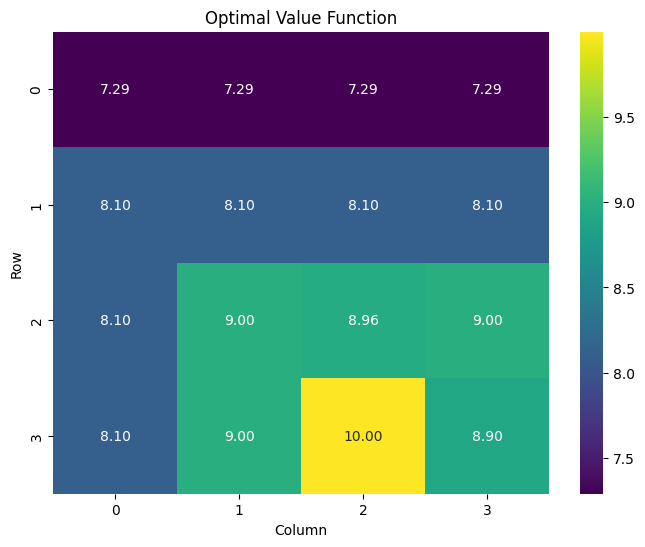

In [20]:
def plot_value_function(env, V):
    """Plot the value function"""
    plt.figure(figsize=(8, 6))
    sns.heatmap(V, annot=True, cmap="viridis", fmt=".2f", cbar=True)
    plt.title("Optimal Value Function")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

# Visualize the value function
plot_value_function(env, V)

## Policy Visualization


Optimal actions for all states:
------------------------------------------------------------
State      Optimal Action       Action Index    Next State      Reward    
------------------------------------------------------------
(0, 0)     DownRight                          4 (1, 1)                0.00
(0, 1)     DownRight                          4 (1, 2)                0.00
(0, 2)     DownRight                          4 (1, 3)                0.00
(0, 3)     DownRight                          4 (1, 3)                0.00
(1, 0)     DownRight                          4 (2, 1)                0.00
(1, 1)     Down                               5 (2, 1)                0.00
(1, 2)     DownRight                          4 (2, 3)                0.00
(1, 3)     DownRight                          4 (2, 3)                0.00
(2, 0)     Right                              3 (2, 1)                0.00
(2, 1)     DownRight                          4 (3, 2)                1.00
(2, 2)     Down     

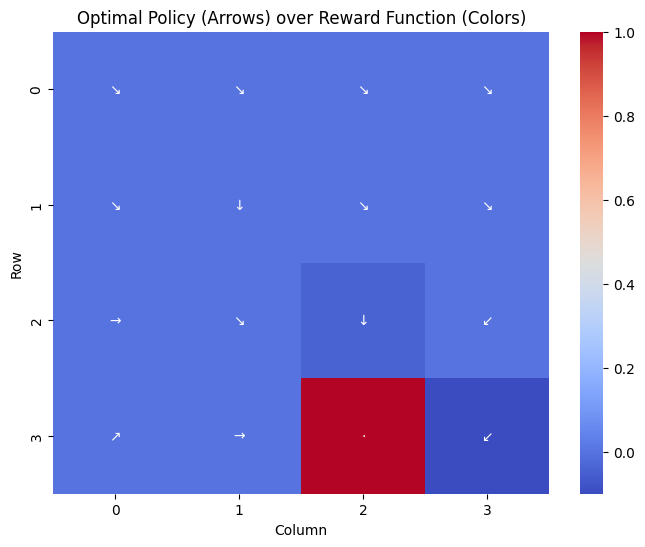

In [21]:
print("\nOptimal actions for all states:")
print("-" * 60)
print(f"{'State':10} {'Optimal Action':20} {'Action Index':15} {'Next State':15} {'Reward':10}")
print("-" * 60)

for row in range(env.height):
    for col in range(env.width):
        state = (row, col)
        action = policy[state]
        action_name = env.action_names[action]
        next_state = env.get_next_state(state, action)
        reward = env.get_reward(next_state)
        
        print(f"{str(state):10} {action_name:20} {action:15} {str(next_state):15} {reward:10.2f}")
        
def plot_policy(env, policy):
    """Plot the policy using arrows"""
    # Symbol mapping for actions
    action_symbols = {
        0: '·',     # NOP
        1: '↑',     # Up
        2: '↗',     # Up-Right
        3: '→',     # Right
        4: '↘',     # Down-Right
        5: '↓',     # Down
        6: '↙',     # Down-Left
        7: '←',     # Left
        8: '↖'      # Up-Left
    }
    
    # Create a matrix of policy symbols
    policy_symbols = np.zeros(policy.shape, dtype=object)
    for row in range(env.height):
        for col in range(env.width):
            policy_symbols[row, col] = action_symbols[policy[row, col]]
    
    # Create a heatmap of the reward function
    plt.figure(figsize=(8, 6))
    sns.heatmap(env.rewards, annot=policy_symbols, fmt='', cmap="coolwarm", cbar=True)
    plt.title("Optimal Policy (Arrows) over Reward Function (Colors)")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

# Visualize the policy
plot_policy(env, policy)

## Episode Simulation

In [22]:
def simulate_episode(env, policy, start_state = env.get_random_state(), max_steps=20):
    """Simulate an episode using the policy"""
    # Start at the specified state
    current_state = start_state
    
    # Keep track of states, actions, and rewards
    states = [current_state]
    actions = []
    rewards = [env.get_reward(current_state)]
    
    # Simulate episode
    for step in range(max_steps):
        row, col = current_state
        action = policy[row, col]
        actions.append(action)
        
        # Take action
        next_state = env.get_next_state(current_state, action)
        reward = env.get_reward(next_state)
        
        # Update state
        current_state = next_state
        states.append(current_state)
        rewards.append(reward)
        
        # If we're at the goal state with NOP action, we can stop
        if current_state == (3, 2) and action == 0:
            break
    
    return states, actions, rewards

# Run simulation with fixed start state for reproducibility
states, actions, rewards = simulate_episode(env, policy, start_state = (0, 2))

## Display Simulation Results

In [23]:
# Print step-by-step information
print("Step-by-step simulation:")
print("-" * 40)
print(f"{'Step':5} {'State':10} {'Action':10} {'Reward':10}")
print("-" * 40)

total_reward = 0
for i in range(len(states)):
    state = states[i]
    reward = rewards[i]
    total_reward += reward
    
    # For each state, show the action that led us there (except for the starting state)
    action_str = env.action_names[actions[i-1]] if i > 0 else "N/A"
    print(f"{i:5} {str(state):10} {action_str:10} {reward:10.2f}")

print("-" * 40)
print(f"Total reward: {total_reward:.2f}")

Step-by-step simulation:
----------------------------------------
Step  State      Action     Reward    
----------------------------------------
    0 (0, 2)     N/A              0.00
    1 (1, 3)     DownRight        0.00
    2 (2, 3)     DownRight        0.00
    3 (3, 2)     DownLeft         1.00
    4 (3, 2)     NOP              1.00
----------------------------------------
Total reward: 2.00


## Trajectory Visualization

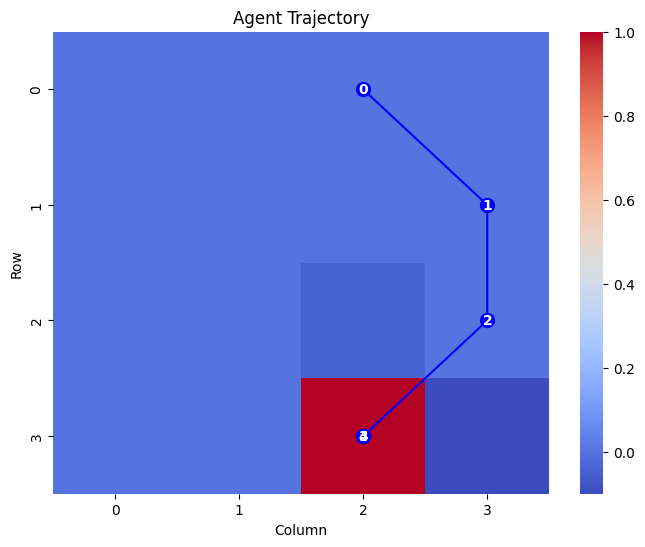

In [24]:
def plot_trajectory(env, states):
    """Plot the trajectory on the grid"""
    grid = np.zeros((env.height, env.width))
    
    # Mark states with step numbers
    for i, (row, col) in enumerate(states):
        grid[row, col] = i
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(env.rewards, cmap="coolwarm", cbar=True)
    
    # Plot trajectory
    rows, cols = zip(*states)
    plt.plot(np.array(cols) + 0.5, np.array(rows) + 0.5, 'bo-', markersize=10)
    
    # Add step numbers
    for i, (row, col) in enumerate(states):
        plt.text(col + 0.5, row + 0.5, str(i), color='white', ha='center', va='center', fontweight='bold')
    
    plt.title("Agent Trajectory")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

# Visualize the trajectory
plot_trajectory(env, states)

## Analysis and Conclusions

In [25]:
print("\nConclusions:")
print("- The optimal policy guides the agent to the goal state [3,2] with the +1 reward")
print("- The agent avoids the negative reward states [2,2] and [3,3]")
print("- Once at the goal state, the optimal action is NOP (stay in place)")
print("- The value function shows propagation of the reward values through the grid")


Conclusions:
- The optimal policy guides the agent to the goal state [3,2] with the +1 reward
- The agent avoids the negative reward states [2,2] and [3,3]
- Once at the goal state, the optimal action is NOP (stay in place)
- The value function shows propagation of the reward values through the grid
